In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mstats
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
%matplotlib inline
plt.style.use("ggplot")

In [2]:
data_student = pd.read_csv('./input/data-attendance-4-1.txt')
data_student.head()

,PersonID,A,Score
0,1,0,69
1,2,1,145
2,3,0,125
3,4,1,86
4,5,1,158


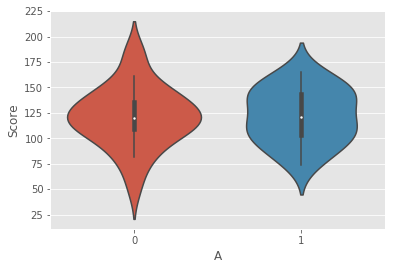

In [3]:
sns.violinplot(data=data_student, x='A', y='Score')

In [4]:
data_student['Score'] /= 200
data_student.head()

,PersonID,A,Score
0,1,0,0.345
1,2,1,0.725
2,3,0,0.625
3,4,1,0.430
4,5,1,0.790


In [5]:
data_cource = pd.read_csv('./input/data-attendance-4-2.txt')
data_cource.head()

,PersonID,CourseID,Weather,Y
0,1,3,B,1
1,1,9,A,1
2,1,1,C,1
3,1,9,A,1
4,1,7,B,1


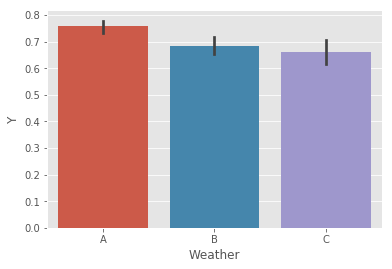

In [6]:
sns.barplot(data=data_cource, x='Weather', y='Y', order=sorted(data_cource['Weather'].unique()))

In [7]:
data_cource['Weather'] = data_cource['Weather'].replace({'A':0, 'B':0.2, 'C':1})
data_cource.head()

,PersonID,CourseID,Weather,Y
0,1,3,0.2,1
1,1,9,0.0,1
2,1,1,1.0,1
3,1,9,0.0,1
4,1,7,0.2,1


In [8]:
stan_model = """

data {
  int N;
  int C;
  int I;
  int<lower=0, upper=1> A[N];
  real<lower=0, upper=1> Score[N];
  int<lower=0, upper=N> PID[I];
  int<lower=0, upper=C> CID[I];
  real<lower=0, upper=1> W[I];
  int<lower=0, upper=1> Y[I];
}

parameters {
  real b[4];
  real b_P[N];
  real b_C[C];
  real<lower=0> s_P;
  real<lower=0> s_C;
}

transformed parameters { 
  real x_P[N];
  real x_C[C];
  real x_J[I];
  real x[I];
  real q[I];
  
  for (n in 1:N){
    x_P[n] = b[2] * A[n] + b[3] * Score[n] + b_P[n];
  }
  
  for (c in 1:C){
    x_C[c] = b_C[c];
  }
  
  for (i in 1:I){
    x_J[i] = b[4] * W[i];
    x[i] = b[1] + x_P[PID[i]] + x_C[CID[i]] + x_J[i];
    q[i] = inv_logit(x[i]);
  }
  
}

model {
  for (n in 1:N){
    b_P[n] ~ normal(0, s_P);
  }
  
  for (c in 1:C){
    b_C[c] ~ normal(0, s_C);
  }
  
  for (i in 1:I){
    Y[i] ~ bernoulli(q[i]);
  }
  
}

generated quantities {
  real y_pred[I];
  
  for (i in 1:I){
    y_pred[i] = bernoulli_rng(q[i]);
  }

}

"""

In [9]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e2792ed702d325a8207dce7520efd6b5 NOW.


In [10]:
stan_data = {}
stan_data['N'] = data_student.shape[0]
stan_data['C'] = len(data_cource['CourseID'].unique())
stan_data['I'] = data_cource.shape[0]
stan_data['A'] = data_student['A']
stan_data['Score'] = data_student['Score']
stan_data['PID'] = data_cource['PersonID']
stan_data['CID'] = data_cource['CourseID']
stan_data['W'] = data_cource['Weather']
stan_data['Y'] = data_cource['Y']

In [11]:
fit = sm.sampling(stan_data)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [12]:
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_e2792ed702d325a8207dce7520efd6b5.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd    2.5%     25%    50%    75%  97.5%  n_eff   Rhat
b[1]        0.76    0.02   0.61    -0.5    0.35   0.76   1.17   1.94    623   1.01
b[2]        -0.8  2.7e-3   0.15   -1.11    -0.9   -0.8   -0.7  -0.51   3237    1.0
b[3]        1.71    0.01   0.59    0.58    1.31    1.7   2.11   2.89   2727    1.0
b[4]       -0.78  1.7e-3   0.15   -1.06   -0.88  -0.78  -0.68  -0.49   7208    1.0
b_P[1]      0.26  4.8e-3    0.3   -0.28    0.06   0.25   0.45    0.9   3770    1.0
b_P[2]     -0.35  5.5e-3   0.27   -0.89   -0.53  -0.34  -0.17   0.17   2348    1.0
b_P[3]     -0.27  5.3e-3   0.31   -0.93   -0.48  -0.26  -0.06   0.33   3523    1.0
b_P[4]      0.38  5.8e-3   0.29   -0.15    0.18   0.36   0.56   1.01   2536    1.0
b_P[5]  -10.0e-3  3.3e-3

LinAlgError: singular matrix

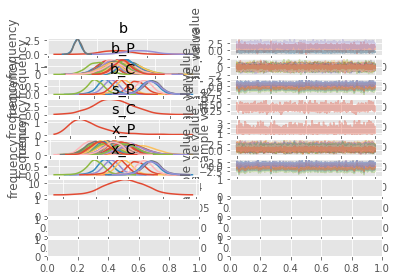

In [13]:
fig = fit.plot()

In [14]:
sample_b1 = fit.extract('b')['b'][:,0]
sample_b2 = fit.extract('b')['b'][:,1]
sample_b3 = fit.extract('b')['b'][:,2]
sample_b4 = fit.extract('b')['b'][:,3]
sample_s_P = fit.extract('s_P')['s_P']
sample_s_C = fit.extract('s_C')['s_C']
sample_b_C = fit.extract('b_C')['b_C']
sample_q = fit.extract('q')['q']

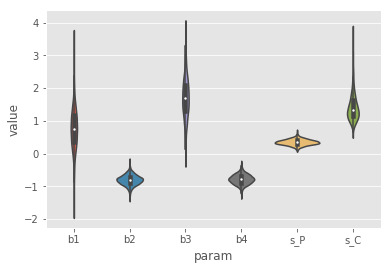

In [15]:
#sample_b1.shape
vio_df = pd.concat([
    pd.DataFrame({'param':'b1', 'value':sample_b1}),
    pd.DataFrame({'param':'b2', 'value':sample_b2}),
    pd.DataFrame({'param':'b3', 'value':sample_b3}),
    pd.DataFrame({'param':'b4', 'value':sample_b4}),
    pd.DataFrame({'param':'s_P', 'value':sample_s_P}), 
    pd.DataFrame({'param':'s_C', 'value':sample_s_C})
])

sns.violinplot(data=vio_df, x='param', y='value')

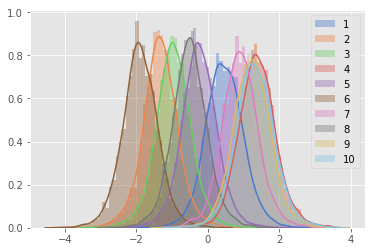

In [16]:
n_course = sample_b_C.shape[1]
cp = sns.color_palette('muted', n_colors=n_course)
for i in range(n_course):
    sns.distplot(sample_b_C[:,i], color=cp[i], label=i+1)
plt.legend()

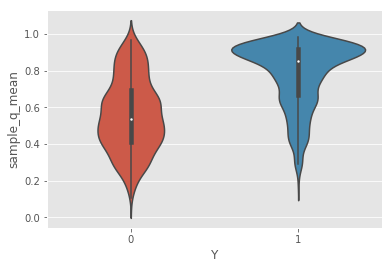

In [17]:
sample_q_mean = np.mean(sample_q, axis=0)
vio_df = pd.DataFrame([])
vio_df['sample_q_mean'] = sample_q_mean
vio_df['Y'] = data_cource['Y']
sns.violinplot(data=vio_df, y='sample_q_mean', x='Y')